## Importando bibliotecas e base

In [1]:
from warnings import filterwarnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage
import time
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.mixture import GaussianMixture
from util import *
import joblib

filterwarnings('ignore')
pd.set_option('display.max_columns', None)
# Ignora os avisos de fonte
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
plt.rcParams['font.family'] = 'DejaVu Sans'

/home/jeanlr/projetos/cluster-telco/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_parquet("../data/df.parquet")
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


## Preparação dos Dados

In [3]:
X = df

cat_attributes = X.select_dtypes(include='object')
num_attributes = X.select_dtypes(exclude='object')

# Define categorical pipeline
cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first'))
])

# Define numerical pipeline with RobustScaler
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

# Combine categorical and numerical pipelines
preprocessor = ColumnTransformer([
    ('cat', cat_pipe, cat_attributes.columns),
    ('num', num_pipe, num_attributes.columns)
])

pipeline = Pipeline(steps=[("preprocessor", preprocessor)])

# Aplica o pipeline à base de dados
X_processed = pipeline.fit_transform(X)

# Obtém os nomes das colunas após o one-hot encoding
encoded_cat_columns = pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']\
    .get_feature_names_out(input_features=cat_attributes.columns)

# Combina os nomes das colunas categóricas codificadas e as colunas numéricas
all_columns = list(encoded_cat_columns) + list(num_attributes.columns)

# Cria um DataFrame com as colunas pré-processadas e seus nomes
df_X_processed = pd.DataFrame(X_processed, columns=all_columns)

In [4]:
# Salvando os objetos com joblib
joblib.dump(pipeline, '../models/preprocessing_pipeline.joblib')
joblib.dump(all_columns, '../models/feature_names.joblib')

['../models/feature_names.joblib']

## Redução de Dimensionalidade

In [5]:
df_X_processed.shape

(7043, 31)

In [6]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 0.9)
pca.fit(df_X_processed)
df_reduced = pca.transform(df_X_processed)
df_reduced.shape

(7043, 16)

## Modelagem - Clusterização

## K-MEANS

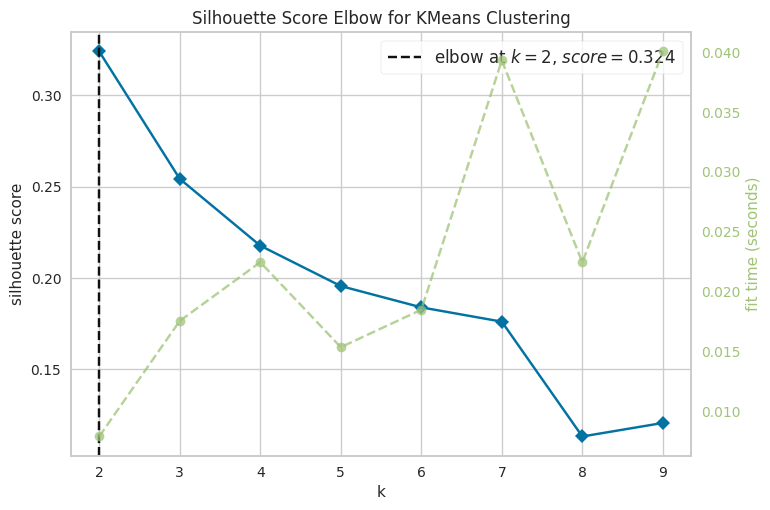

In [9]:
import logging
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

# Elbow Method for K means
# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = KMeans(random_state=0, n_init='auto')
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,10),metric='silhouette', timings= True);
visualizer.fit(df_reduced)        # Fit the data to the visualizer
visualizer.show();

## Treino do Modelo K-means

In [10]:
# Treinar o algoritmo K-means com 4 clusters
kmeans = KMeans(n_clusters=3, random_state=0, n_init='auto')
kmeans.fit(df_reduced)

# Obter os centróides dos clusters
centroids = kmeans.cluster_centers_
labels = kmeans.labels_

df['Cluster'] = labels

np.unique(labels)

array([0, 1, 2], dtype=int32)

In [11]:
# Salvando os objetos com joblib
joblib.dump(kmeans, '../models/kmeans_model.joblib')

['../models/kmeans_model.joblib']

## Mistura Gaussiana

In [10]:
n_components = range(1, 10)
covariance_type = ['spherical', 'tied', 'diag', 'full']
best_bic = float('inf')  # Inicialize com um valor infinito
best_config = None
bic_scores = []

for cov in covariance_type:
    for n_comp in n_components:
        gmm = GaussianMixture(n_components=n_comp, covariance_type=cov, random_state=0)
        gmm.fit(df_reduced)
        bic_score = gmm.bic(df_reduced)
        bic_scores.append((cov, n_comp, bic_score))

        if bic_score < best_bic:
            best_bic = bic_score
            best_config = (cov, n_comp)

print("Melhor configuração:", best_config)
print("Menor BIC:", best_bic)

Melhor configuração: ('full', 8)
Menor BIC: -41505.93735416421


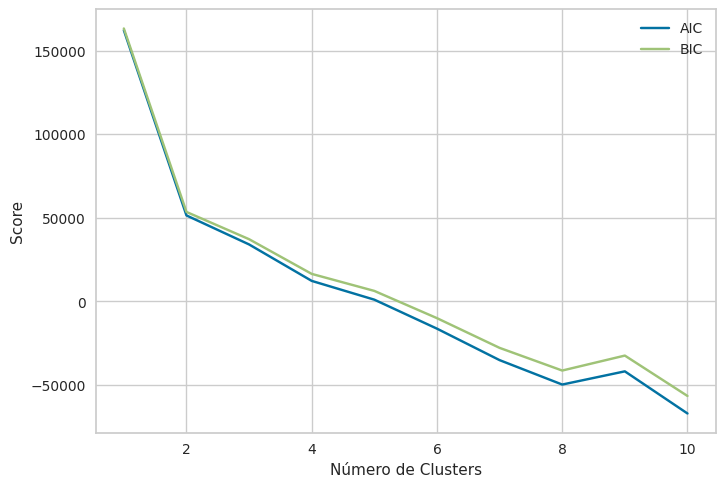

In [12]:

# Lista para armazenar valores de AIC e BIC
aic_scores = []
bic_scores = []

# Testar diferentes números de clusters
for n_clusters in range(1, 11):
    gmm = GaussianMixture(n_components=n_clusters, covariance_type='full', random_state=0)
    gmm.fit(df_reduced)
    aic_scores.append(gmm.aic(df_reduced))
    bic_scores.append(gmm.bic(df_reduced))

# Plotar AIC e BIC em função do número de clusters
import matplotlib.pyplot as plt

plt.plot(range(1, 11), aic_scores, label='AIC')
plt.plot(range(1, 11), bic_scores, label='BIC')
plt.xlabel('Número de Clusters')
plt.ylabel('Score')
plt.legend()
plt.show()


## Treino do Modelo Mistura Gaussiana

In [12]:
# Inicializar o modelo de Mistura Gaussiana
gmm = GaussianMixture(n_components=8, covariance_type='full', random_state=0)

# Ajustar o modelo aos dados com parâmetros de inicialização específicos
gmm.fit(df_reduced)

# Prever os rótulos dos clusters
labels = gmm.predict(df_reduced)

df['Cluster'] = labels

labels = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=np.int64)
labels = labels.astype(int)

np.unique(labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

## Análise dos Clusters Gerados - K-MEANS

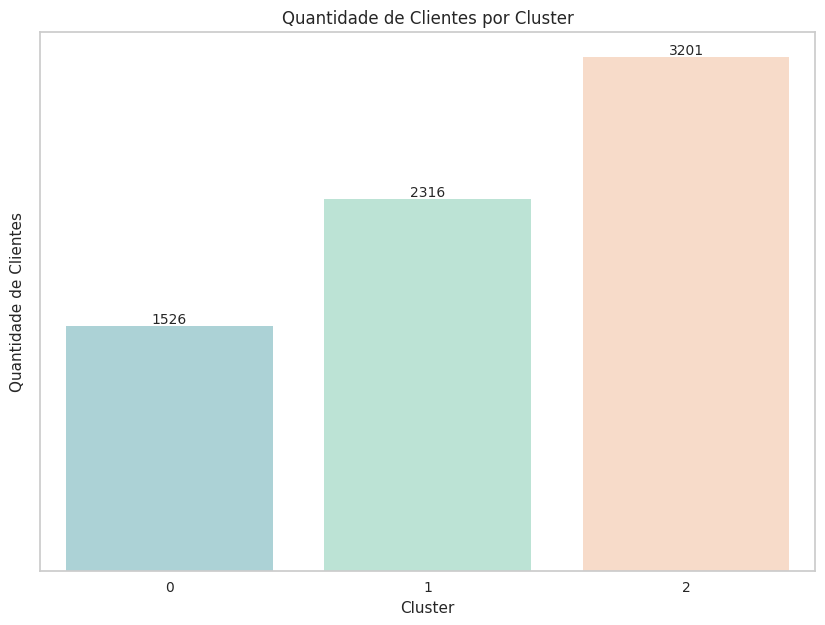

In [28]:
pal = ['#A5D8DD', '#B5EAD7', '#FFDAC1', '#E2F0CB', '#C7CEEA', '#F8B195', '#F67280', '#6C5B7B']
pal = pal[:len(np.unique(labels))]

plt.figure(figsize=(10,7))
pl = sns.countplot(data=df, x="Cluster", palette=pal)

for i in range(len(pl.containers)):
  pl.bar_label(pl.containers[i], fontsize=10)
pl.set_title("Quantidade de Clientes por Cluster")
plt.gca().axes.yaxis.set_ticklabels([])
plt.ylabel('Quantidade de Clientes')
plt.grid(False)
plt.show()

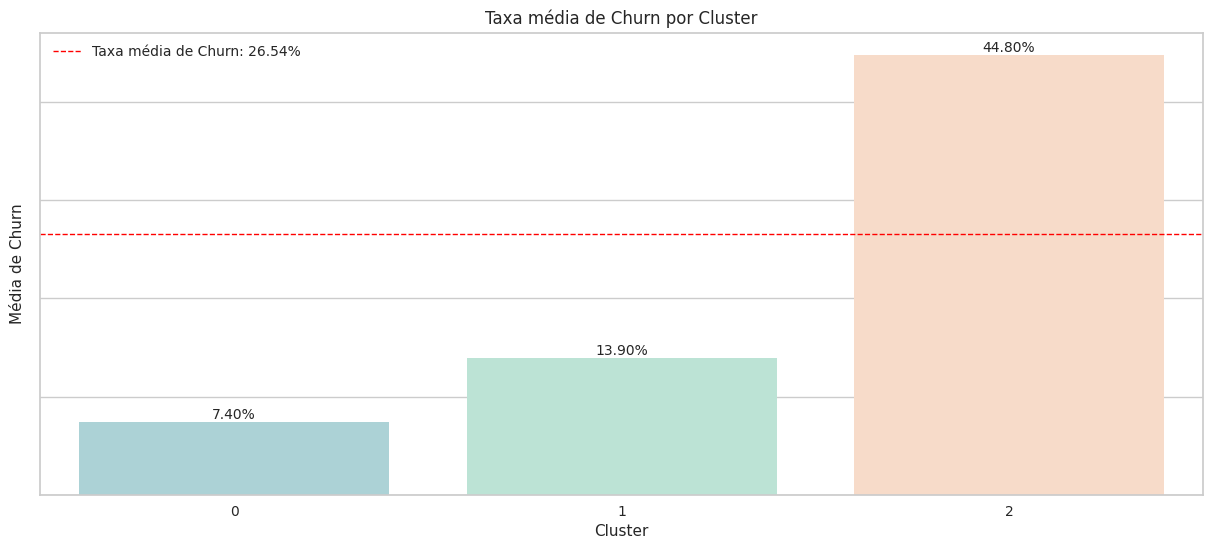

In [14]:
df['TARGET'] = (df['Churn'] == 1).astype(int)

# Calcular a média da variável "Rotatividade" para cada cluster
mean_rotatividade_by_cluster = df.groupby("Cluster")["TARGET"].mean().reset_index()

overall_mean_churn = df['TARGET'].mean()

# Plot the barplot
plt.figure(figsize=(15, 6))
sns.barplot(x="Cluster", y="TARGET", data=mean_rotatividade_by_cluster, palette=pal)

# Plot the overall mean churn rate as a dashed line
plt.axhline(overall_mean_churn, color='red', linestyle='dashed', linewidth=1, label='Taxa média de Churn: {:.2f}%'.format(overall_mean_churn * 100))

plt.title("Taxa média de Churn por Cluster")
plt.xlabel("Cluster")
plt.ylabel("Média de Churn")

# Add the churn rate values on the bars
for i, taxa in enumerate(mean_rotatividade_by_cluster.TARGET.values):
    plt.text(i, taxa, '{:.2f}%'.format(taxa * 100), ha='center', va='bottom', fontsize=10)

plt.gca().axes.yaxis.set_ticklabels([])
plt.legend()
plt.show()

## Categoricas

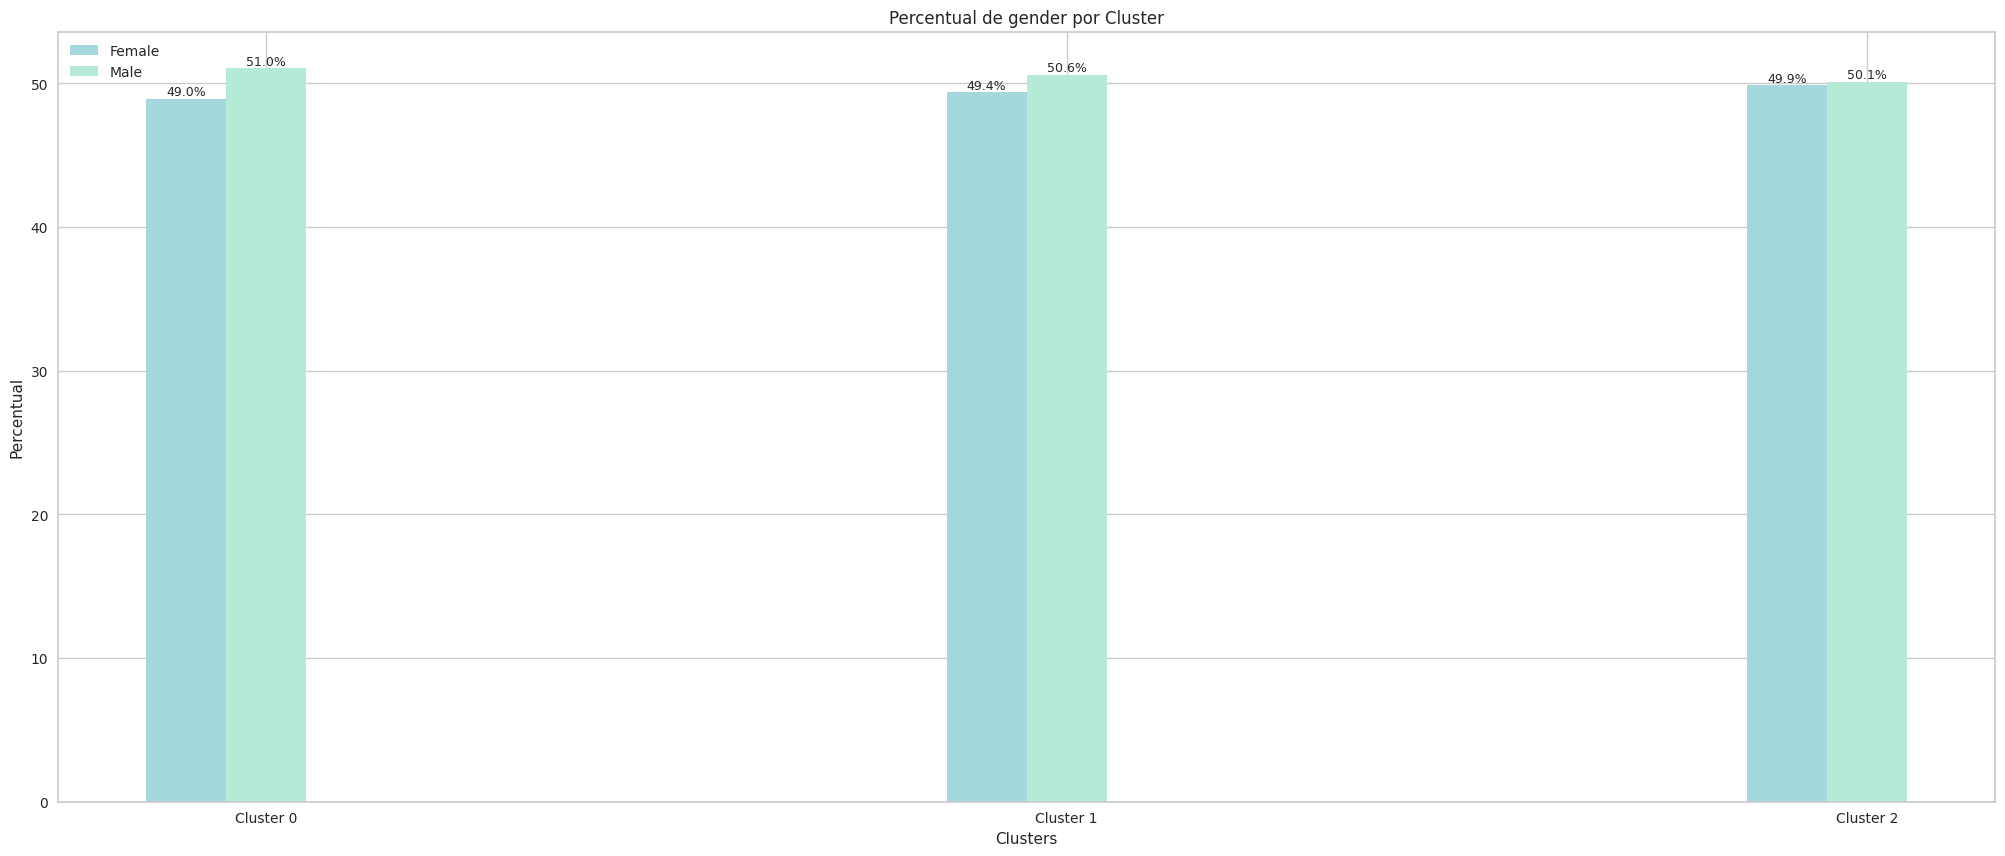

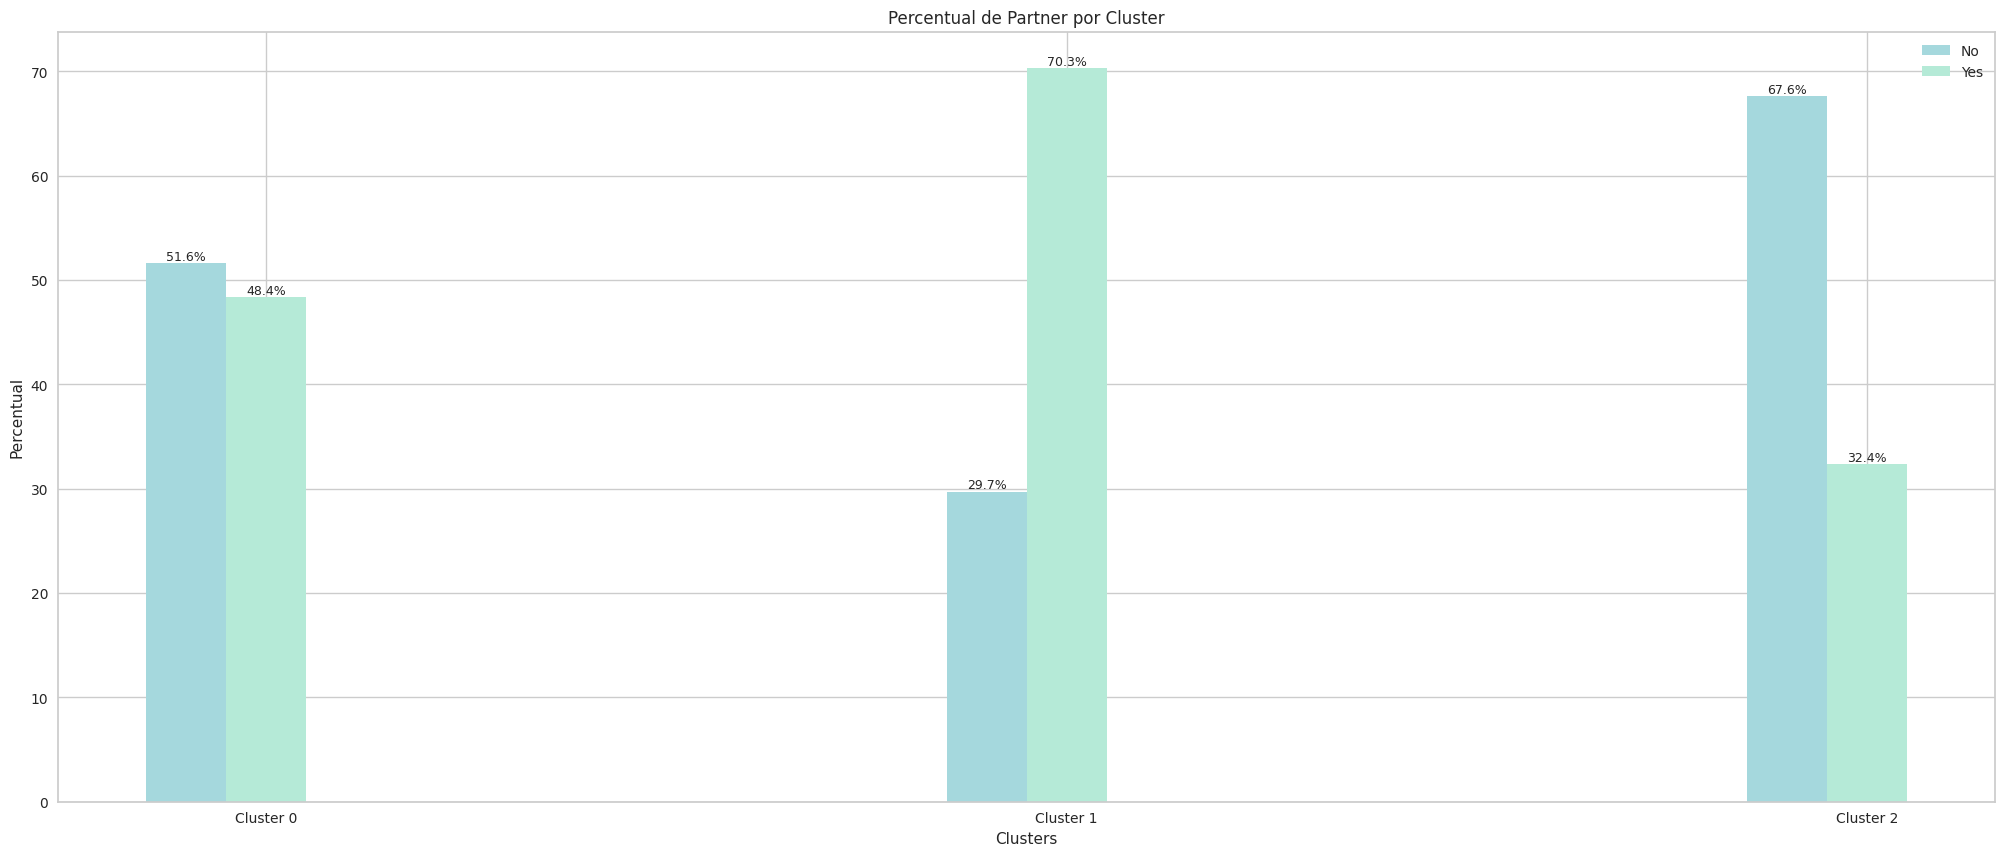

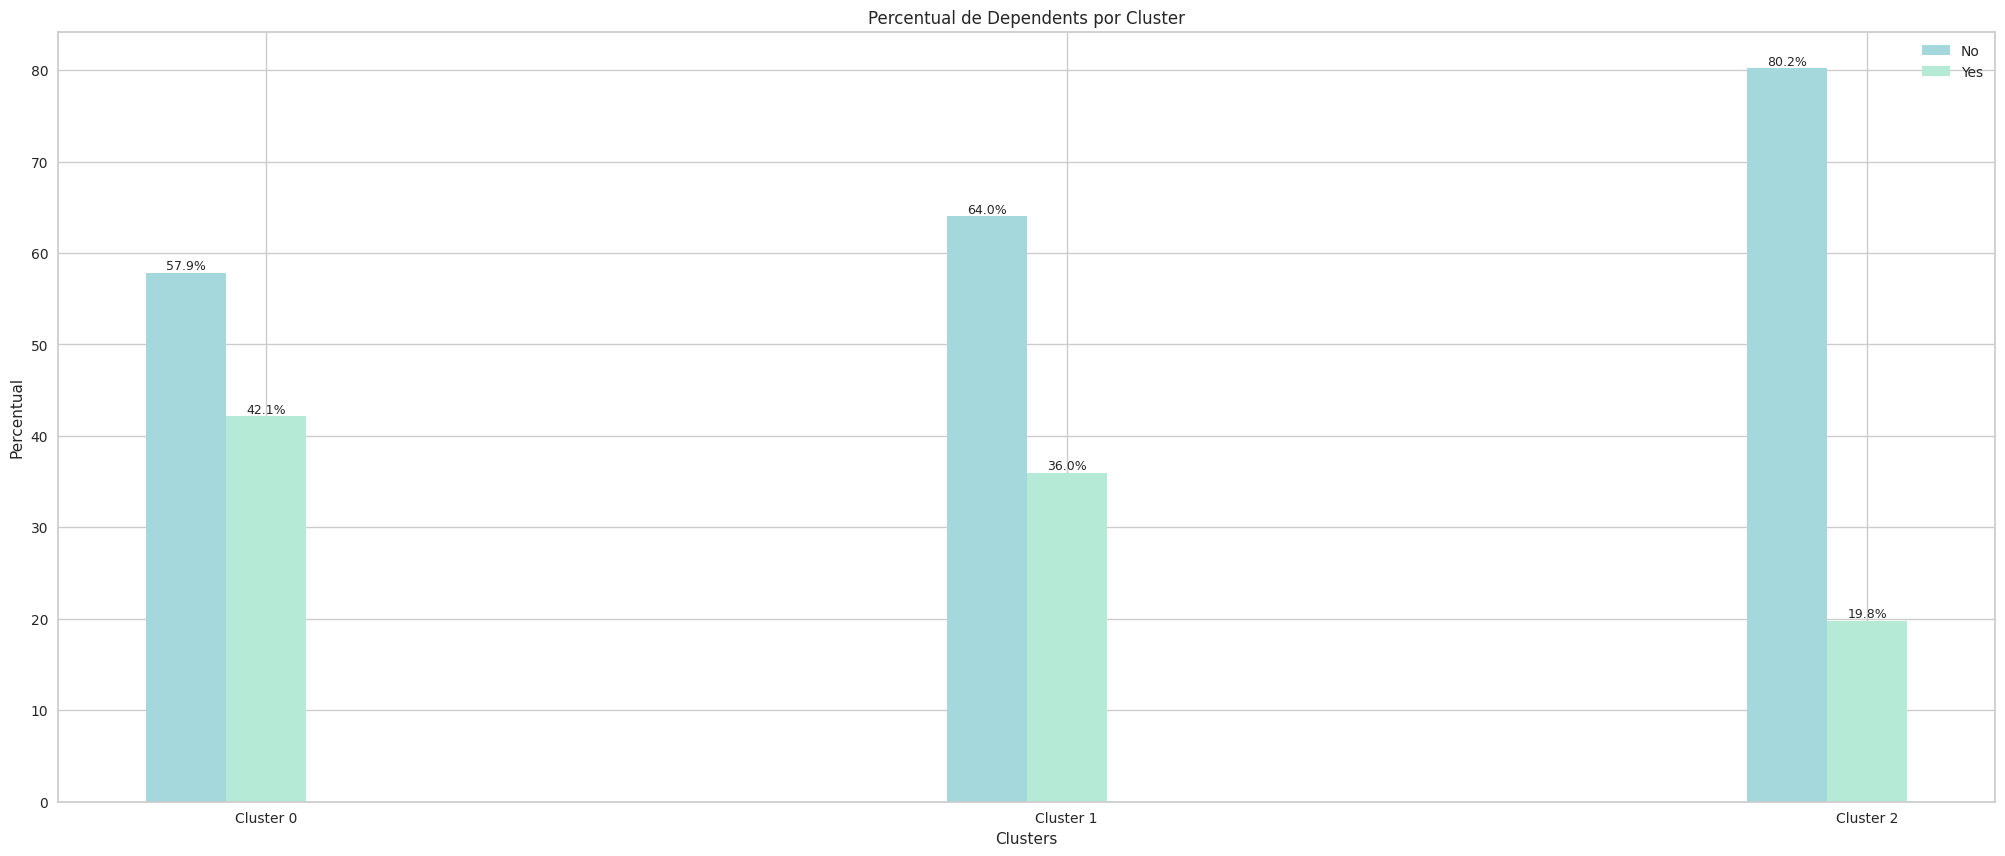

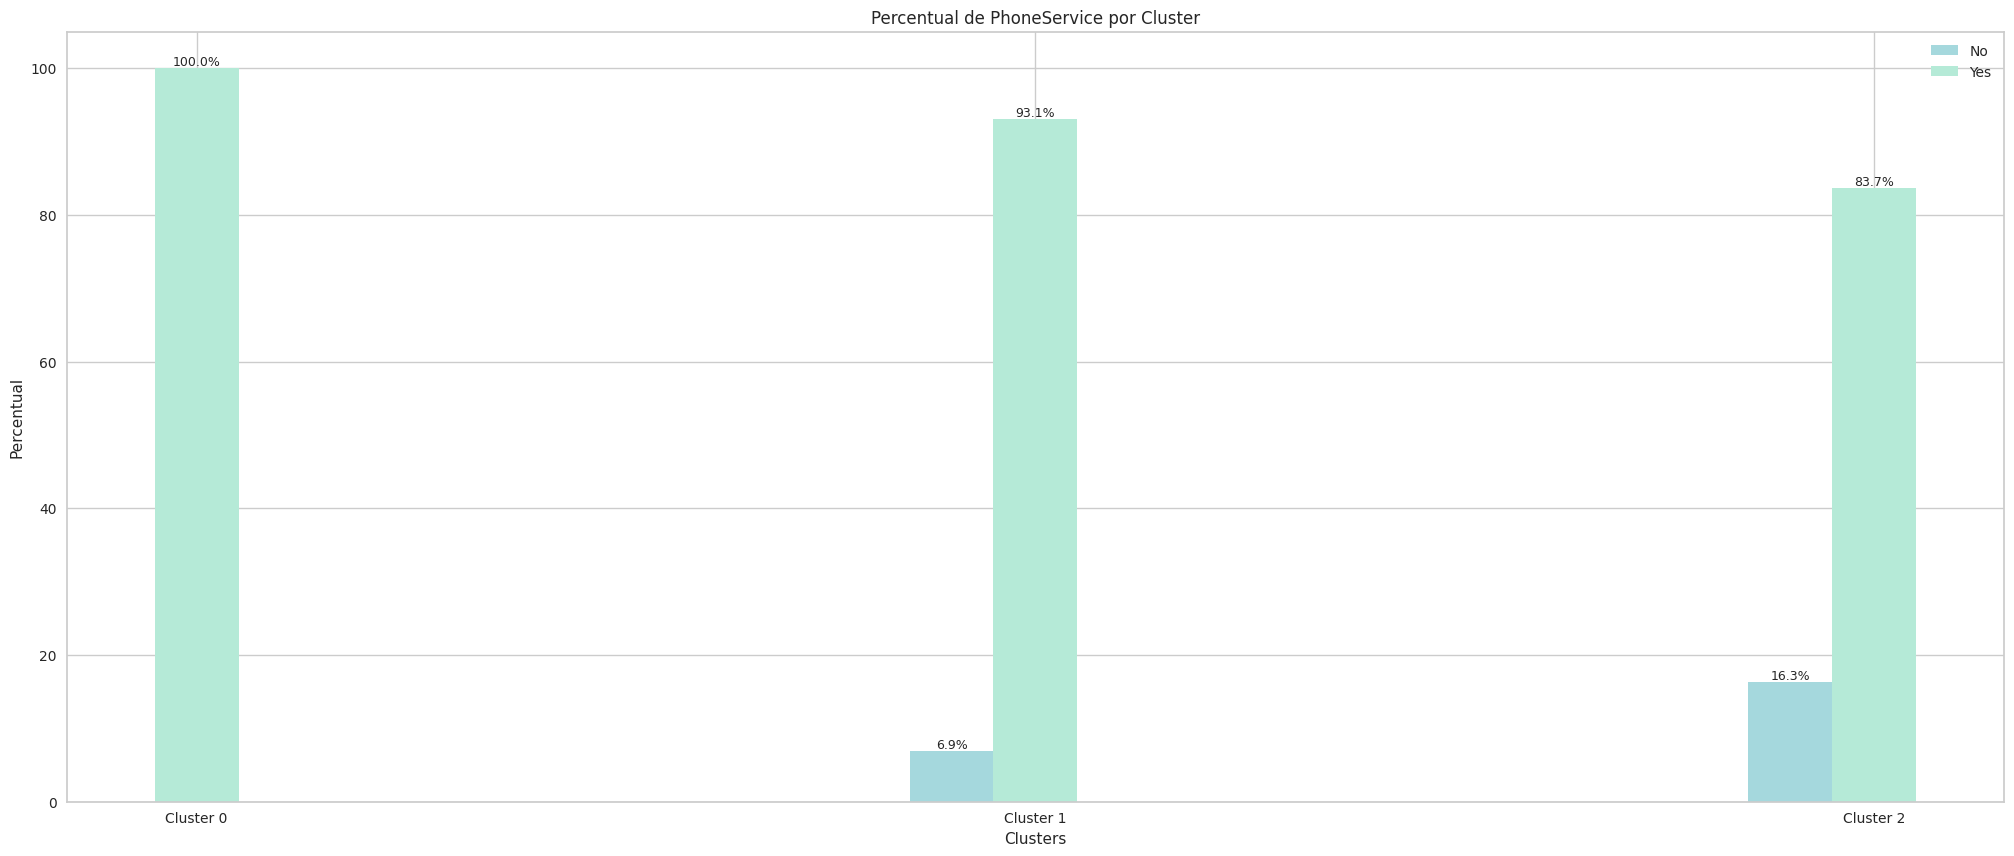

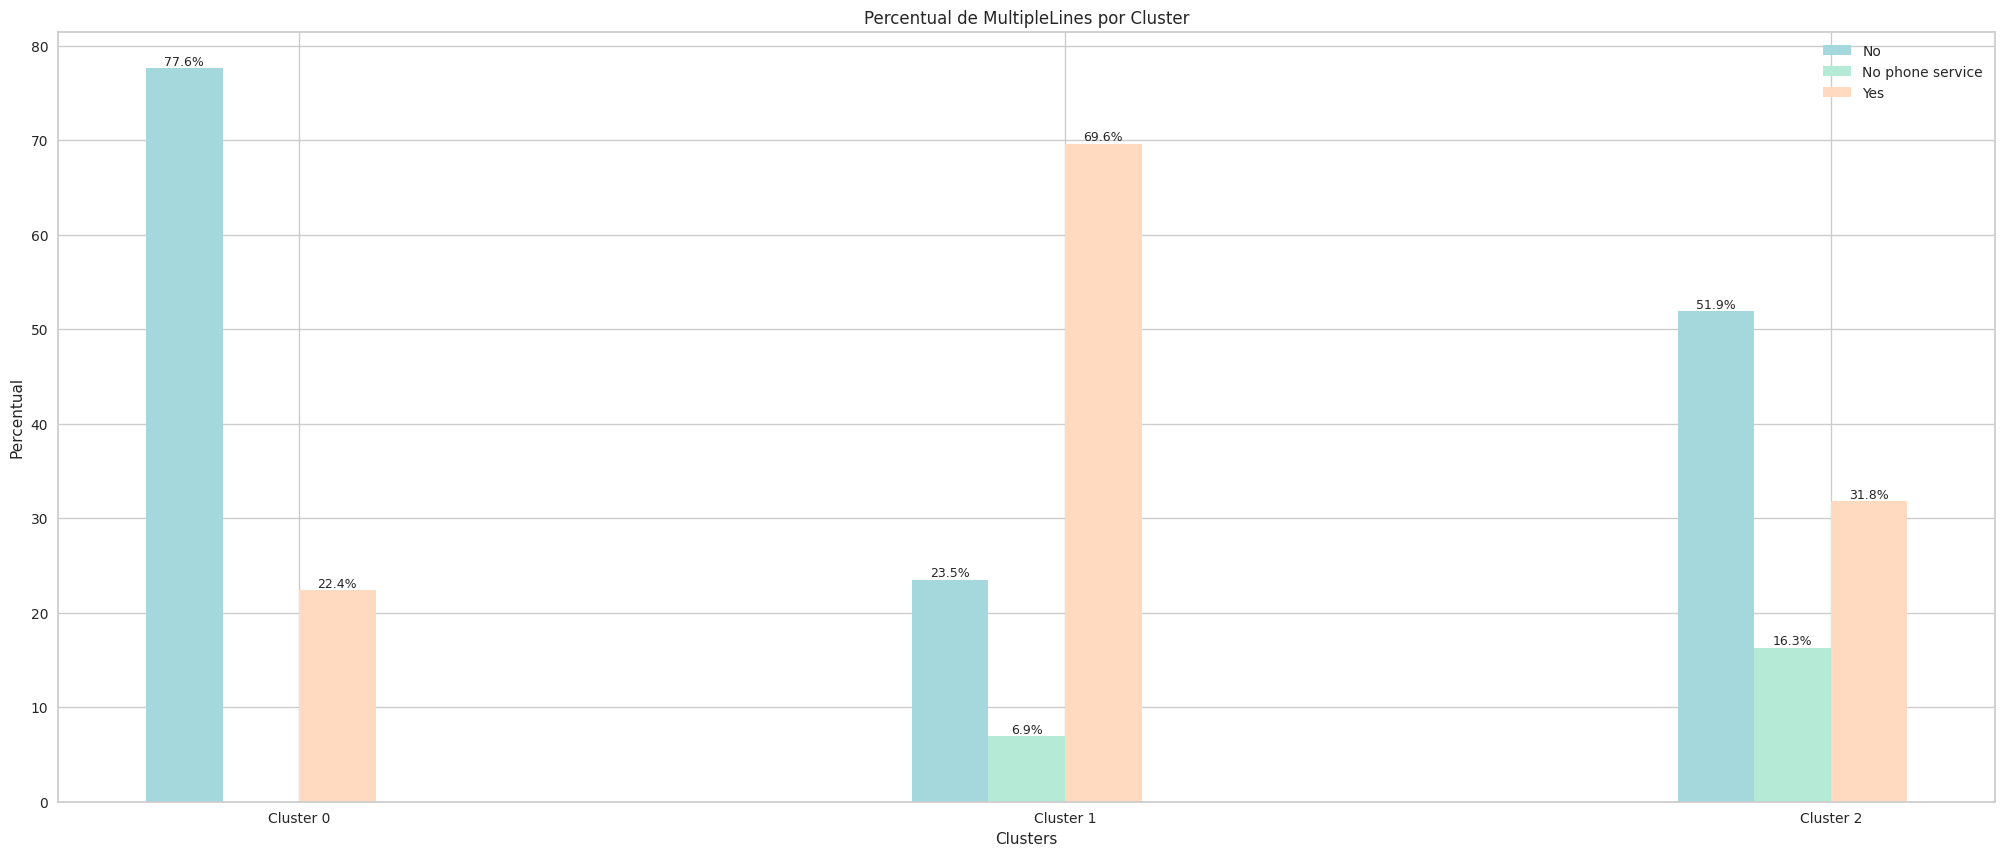

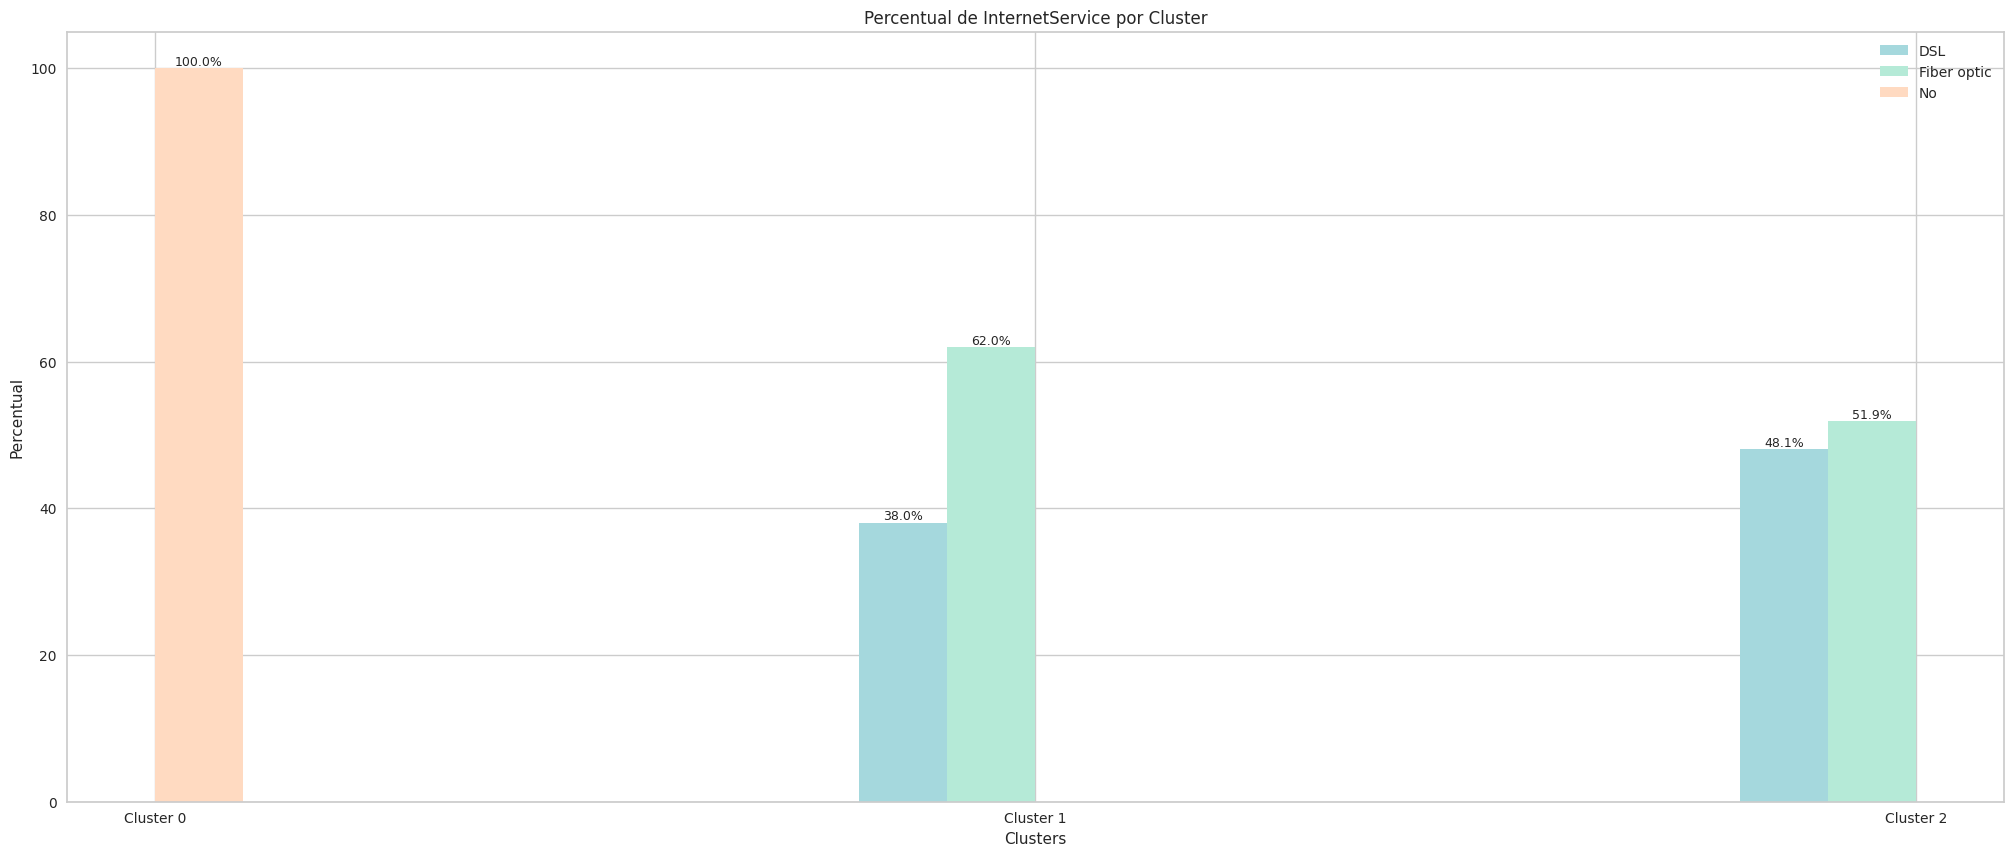

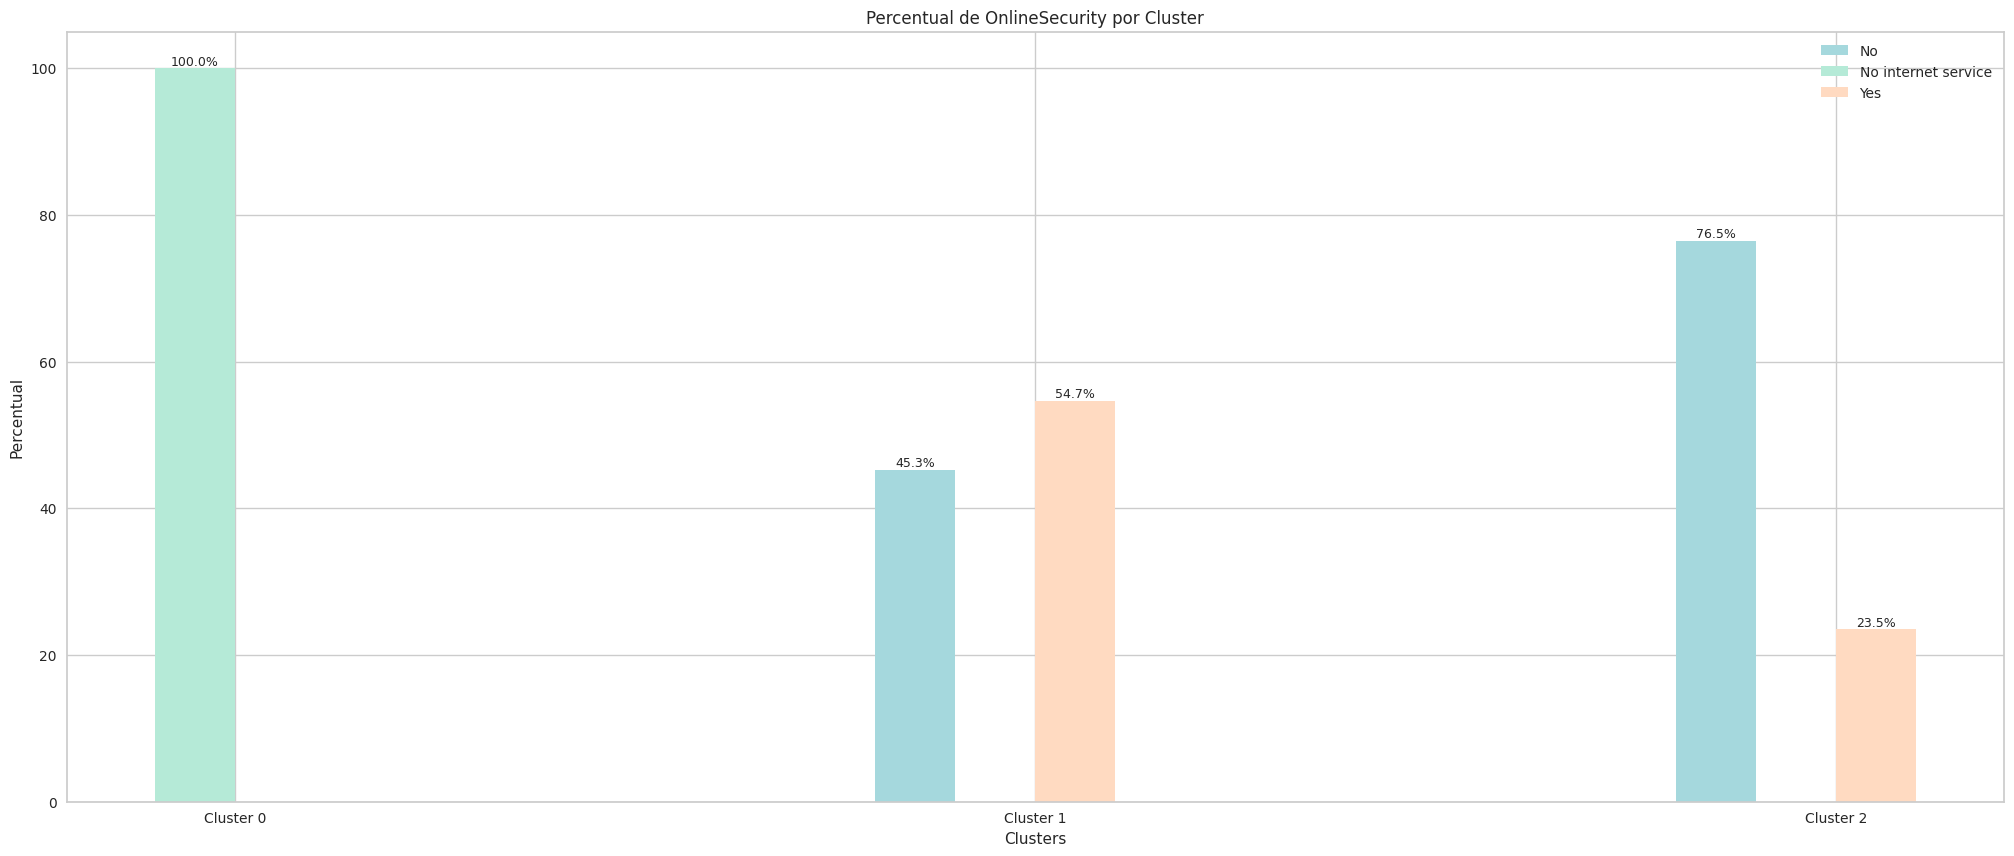

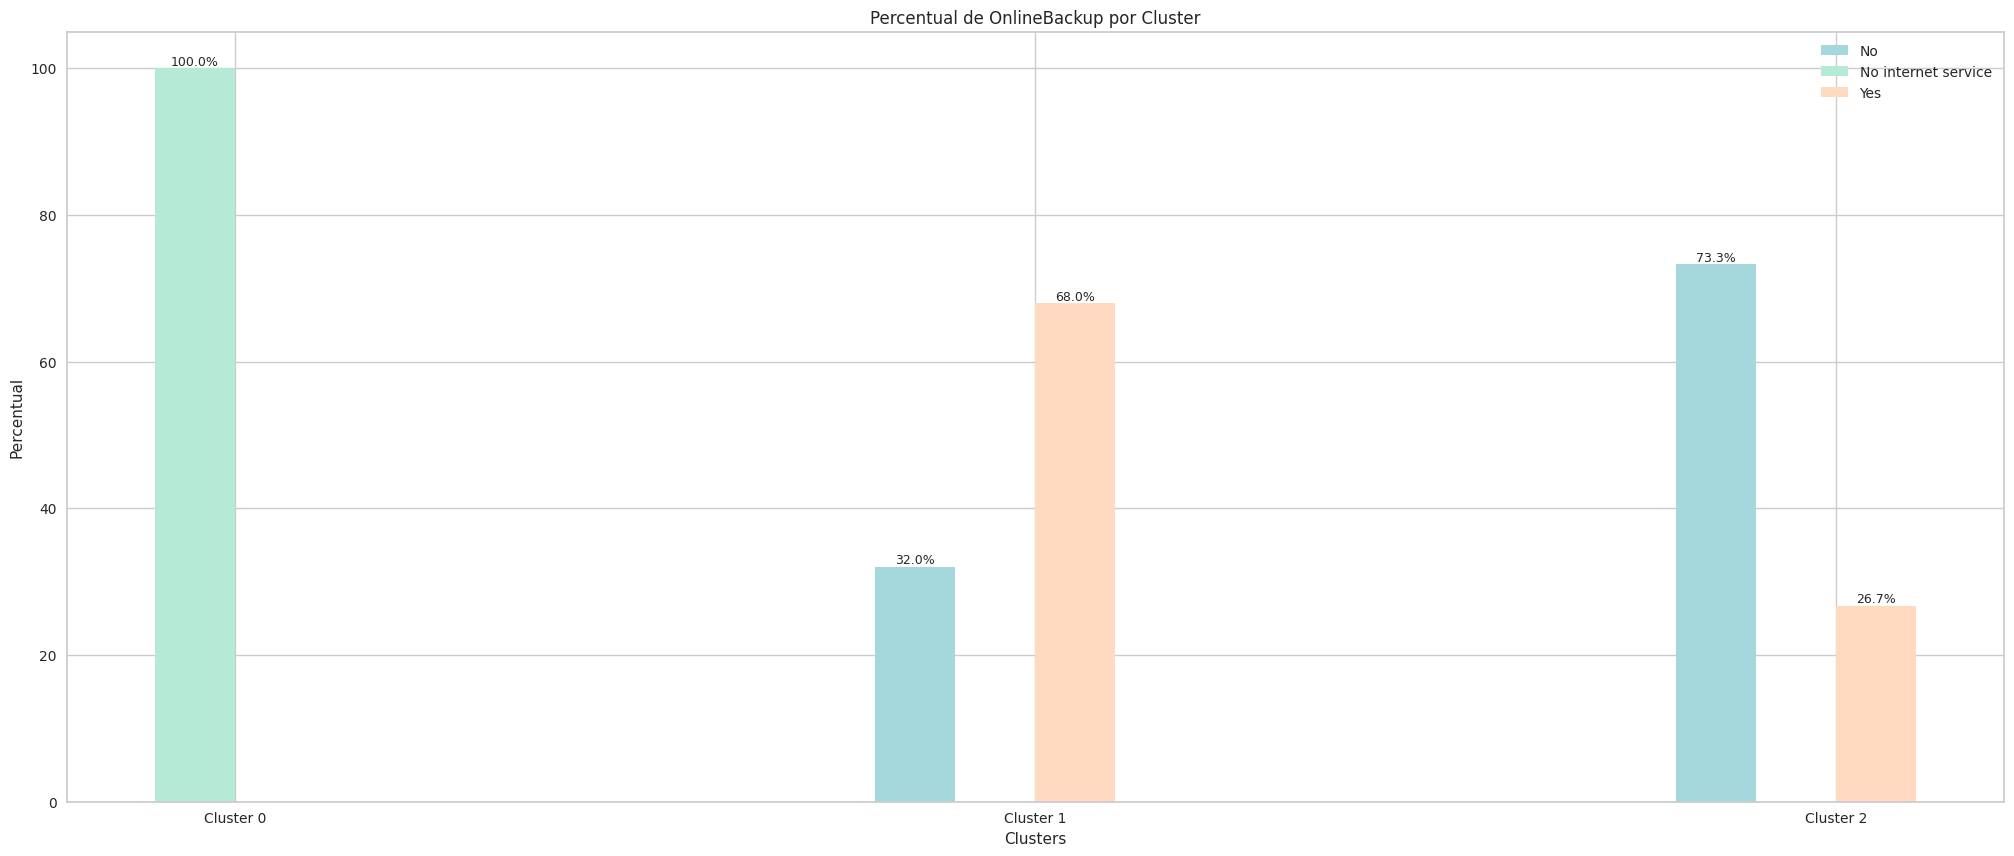

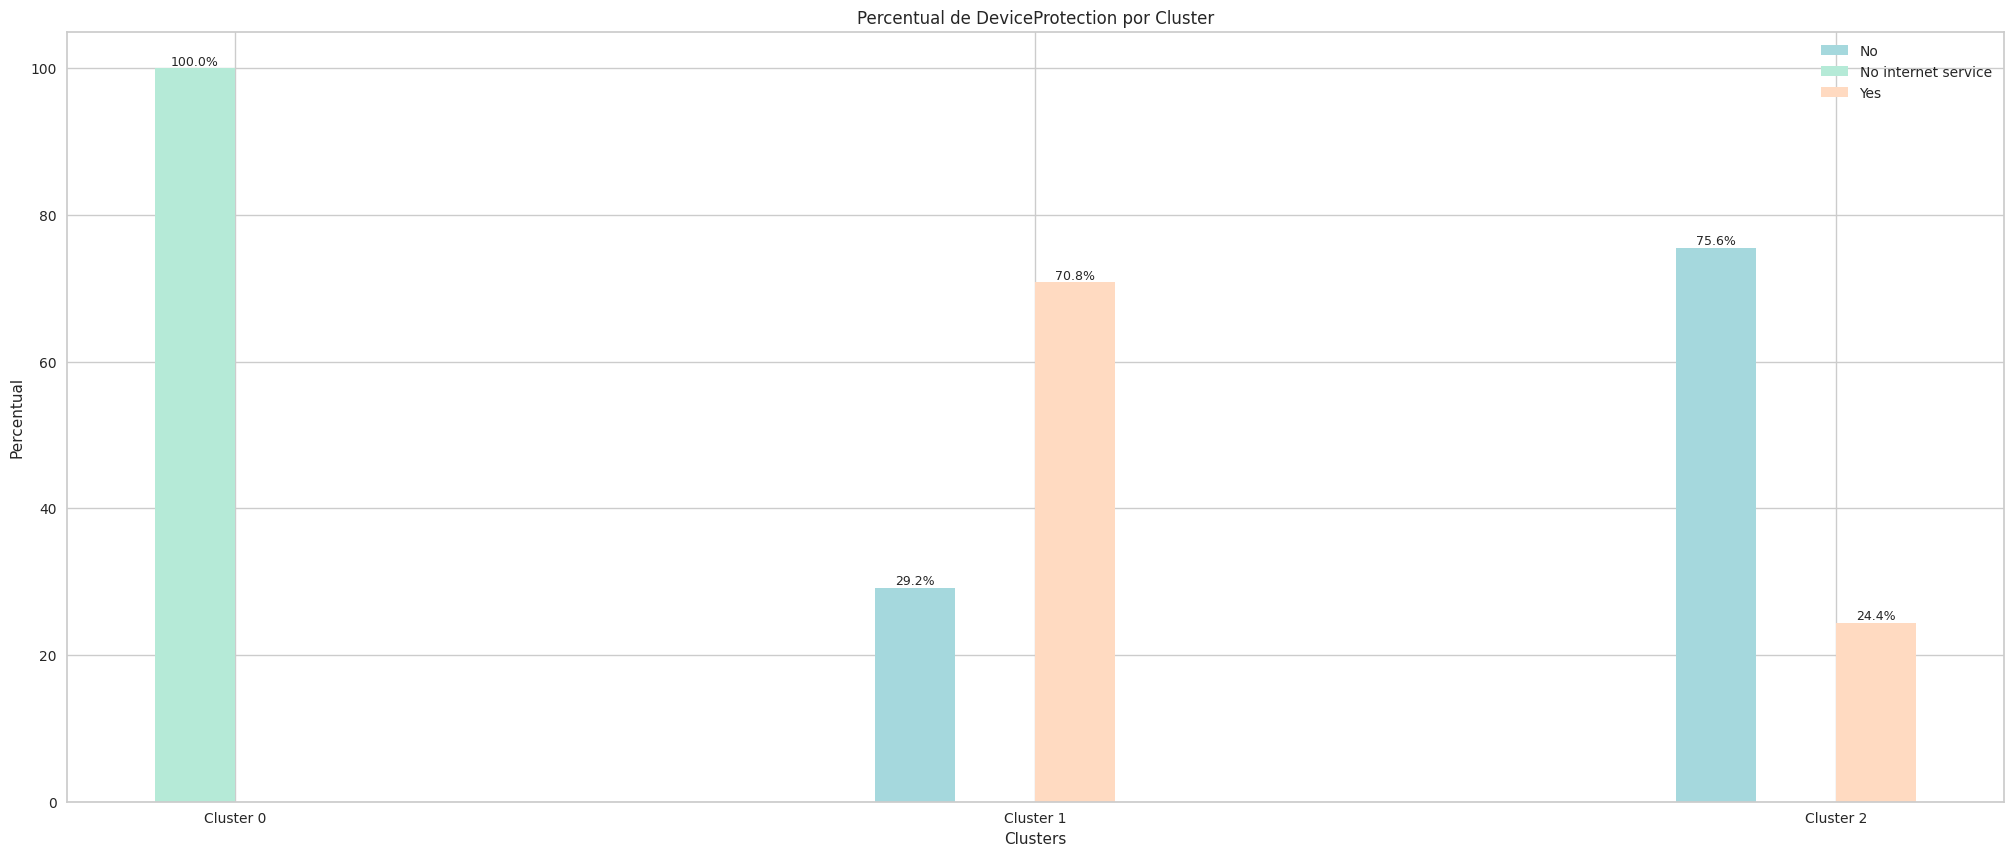

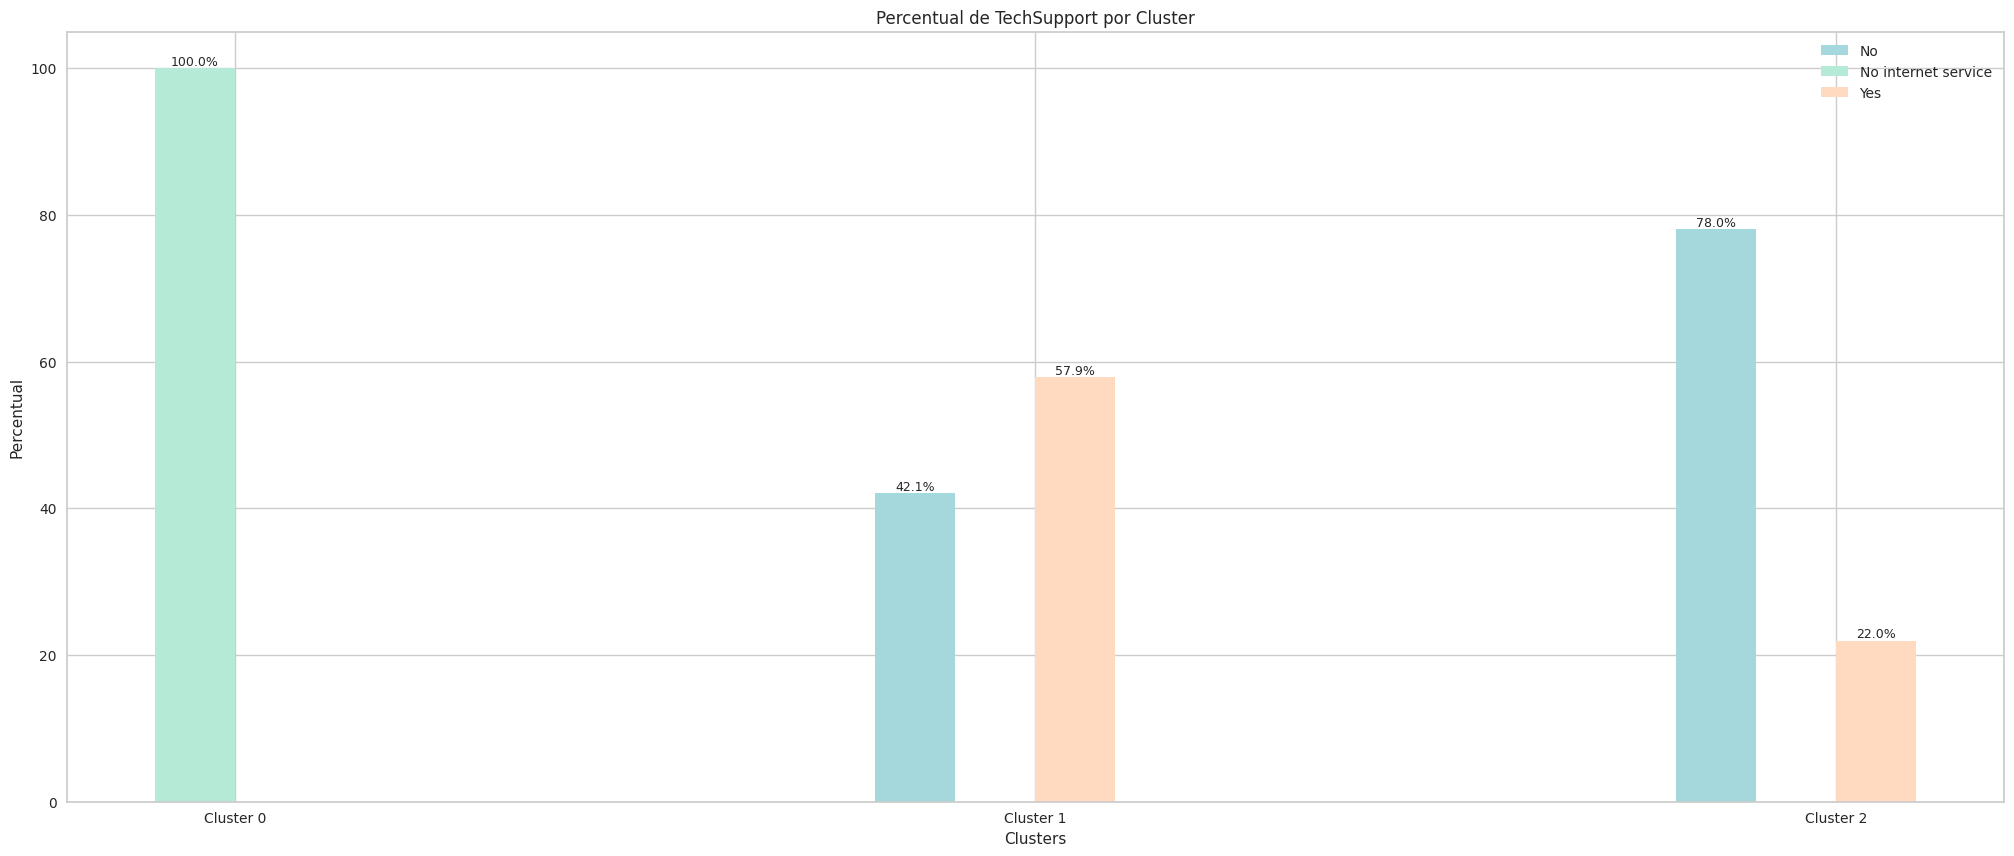

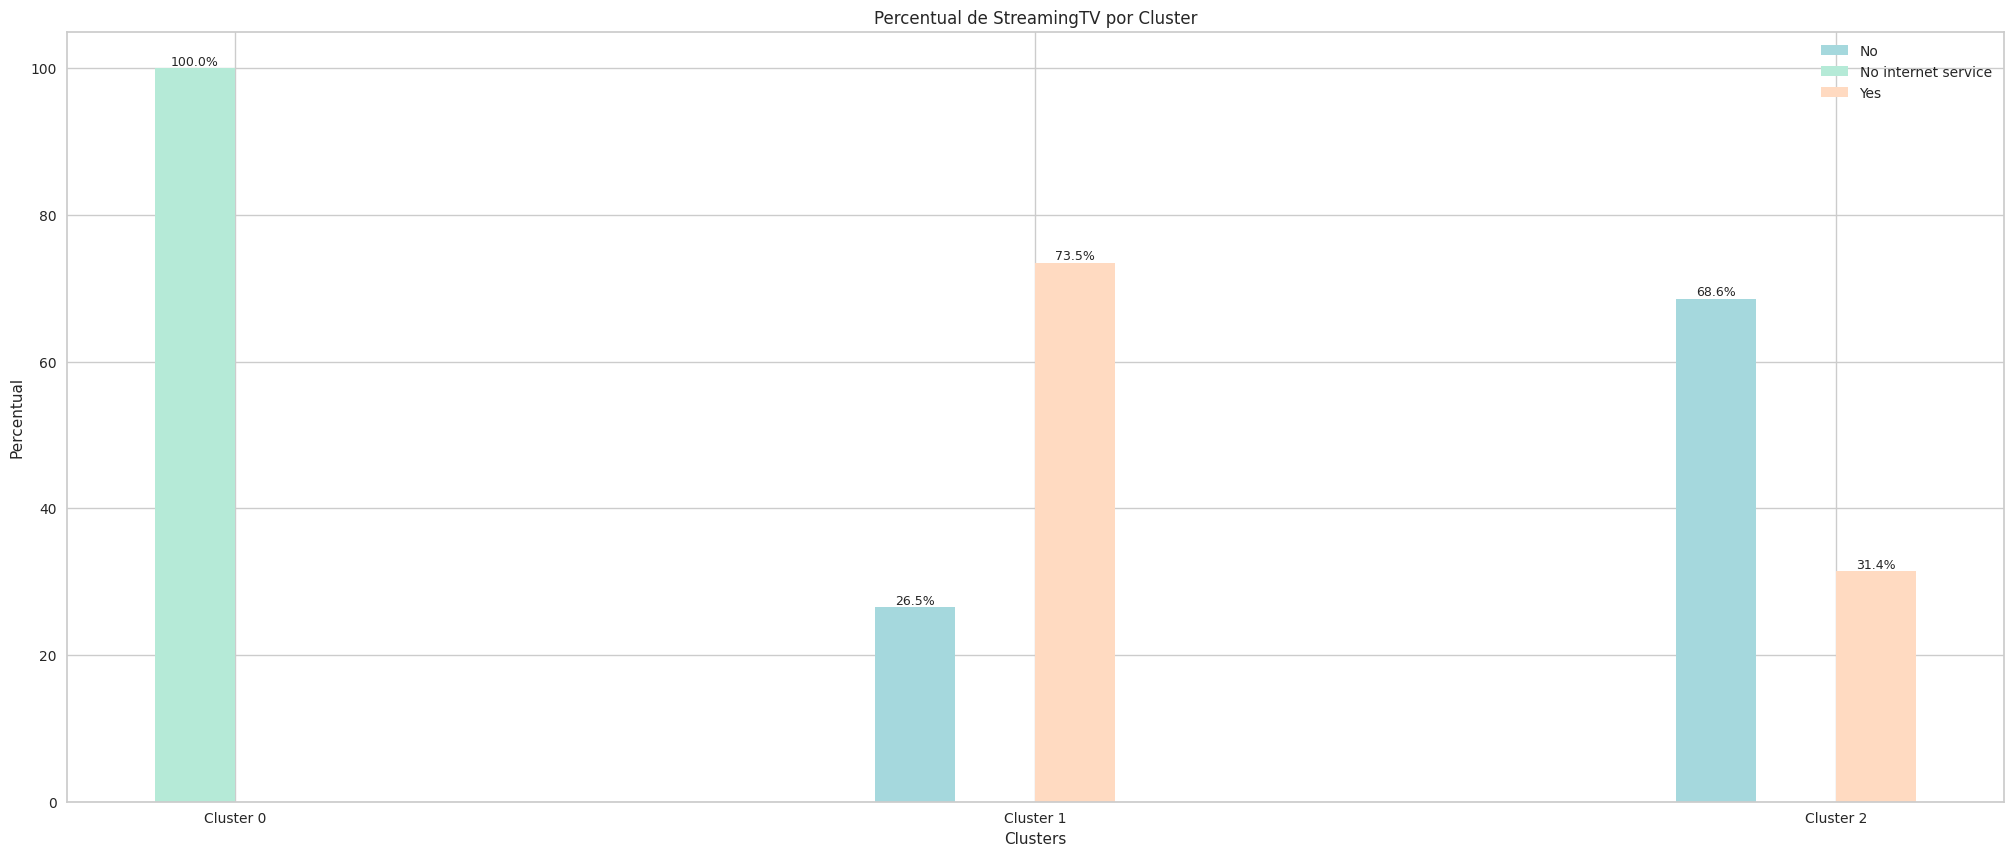

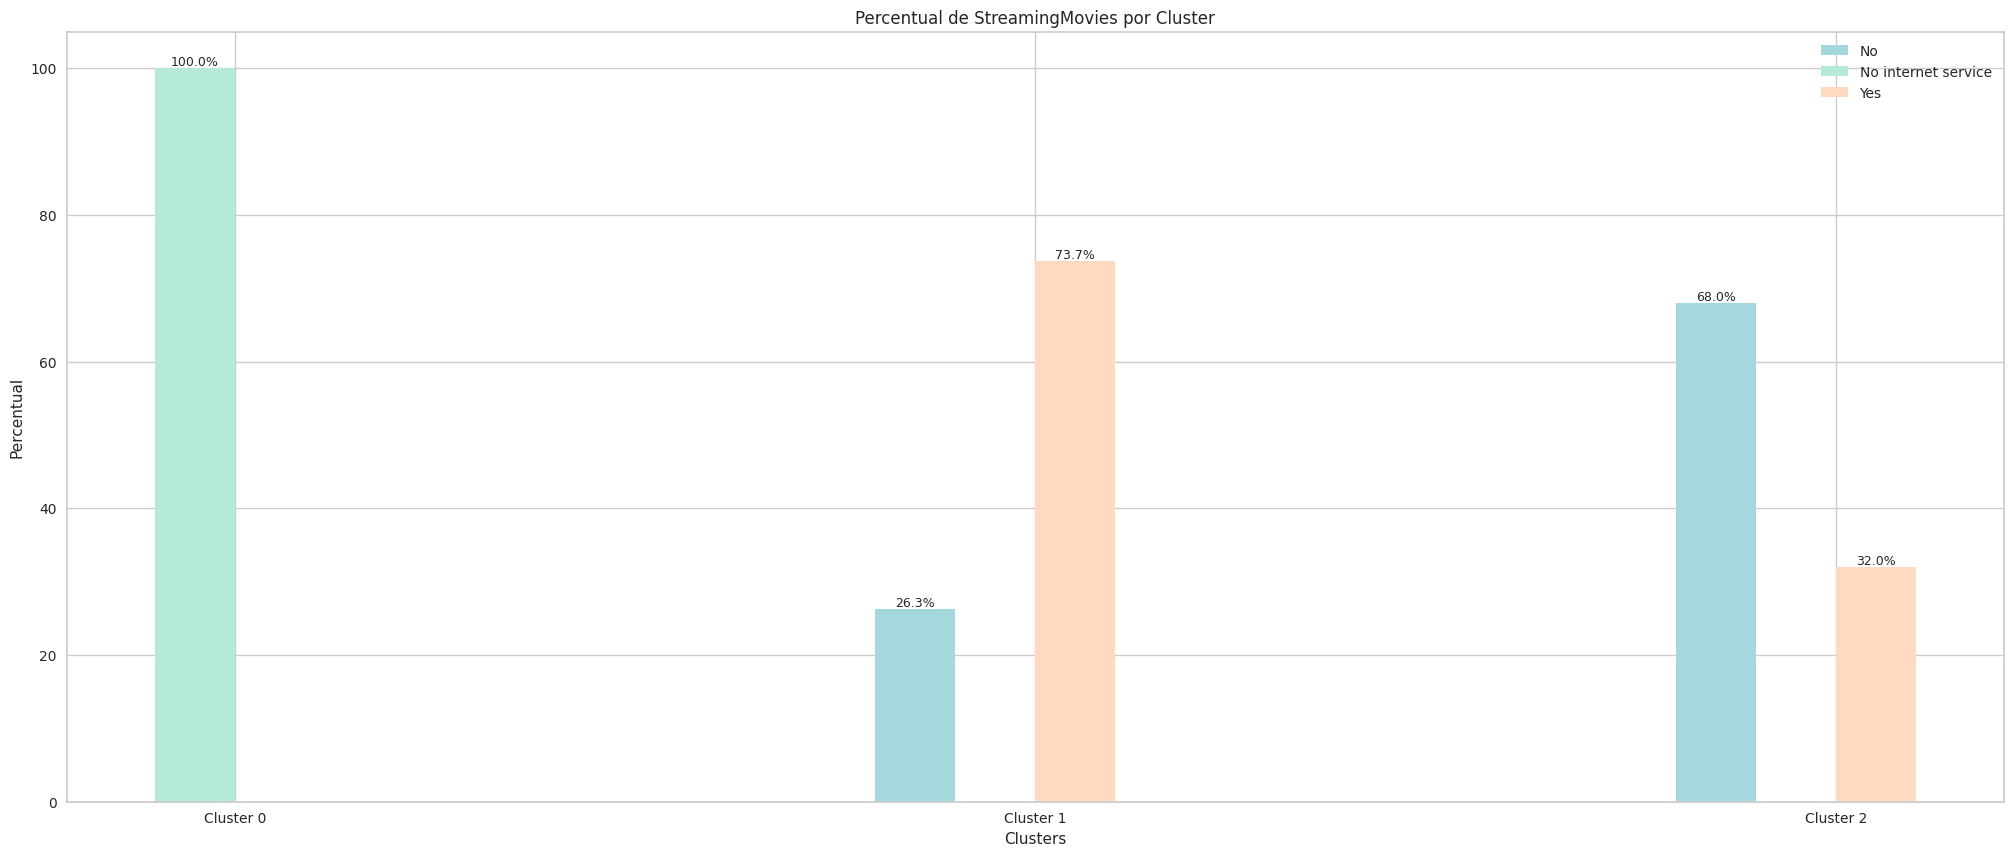

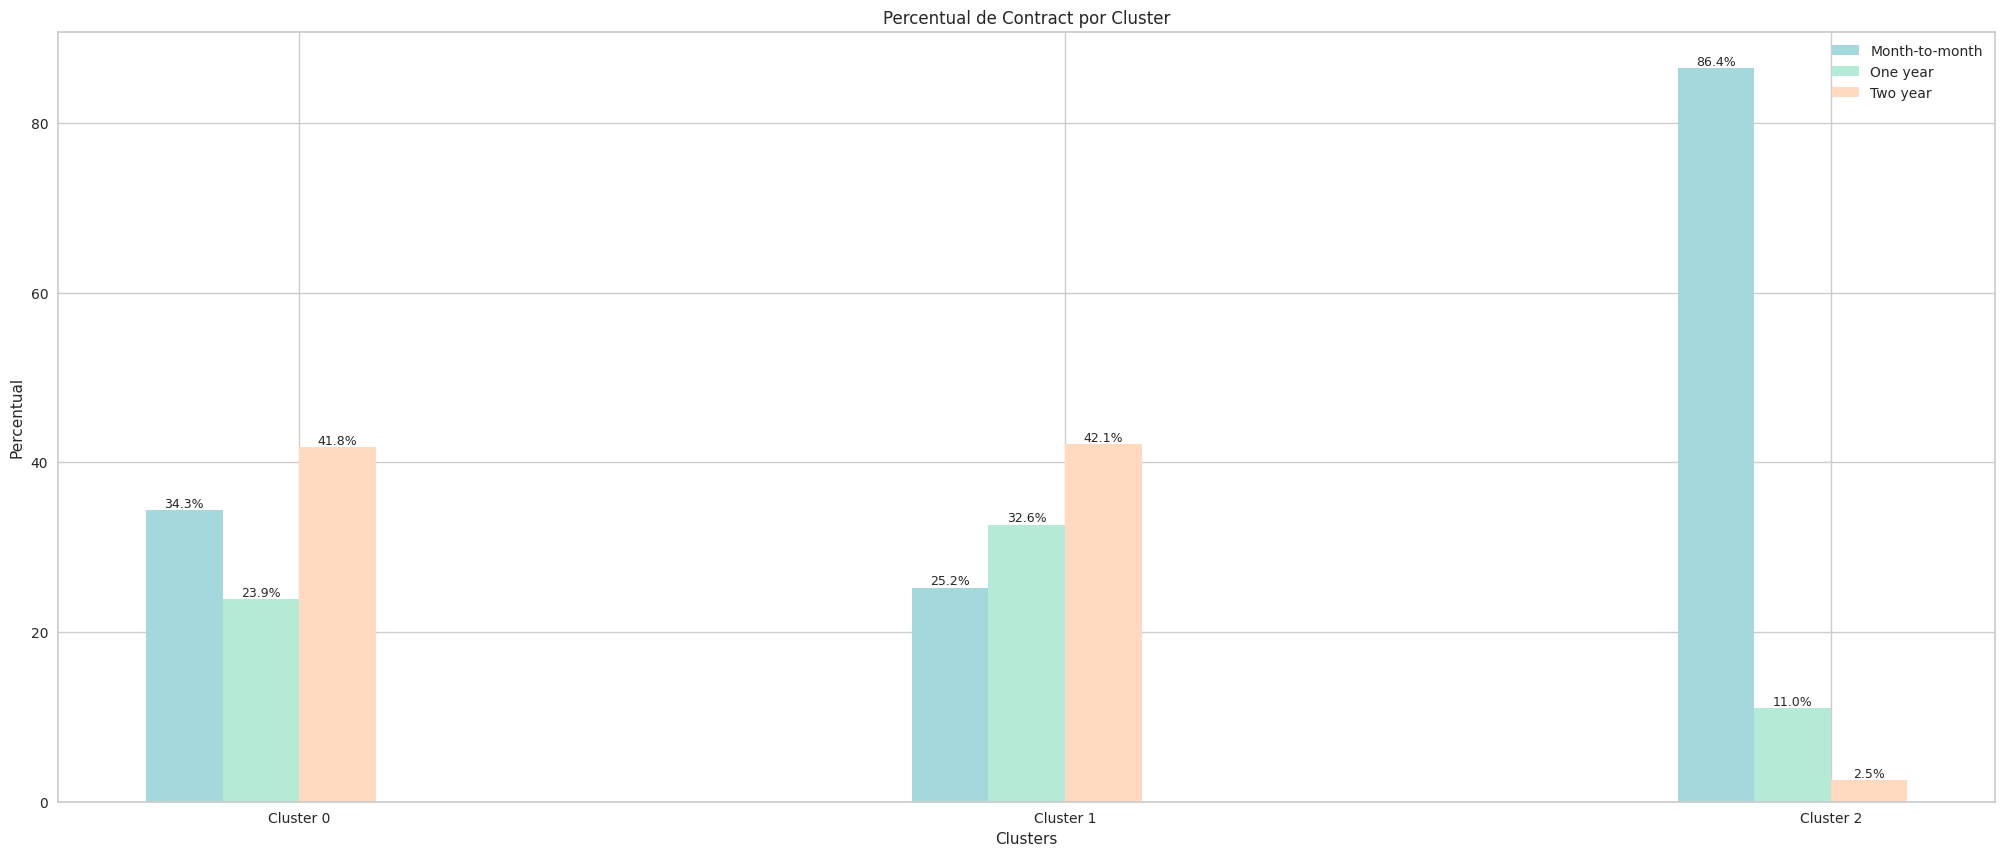

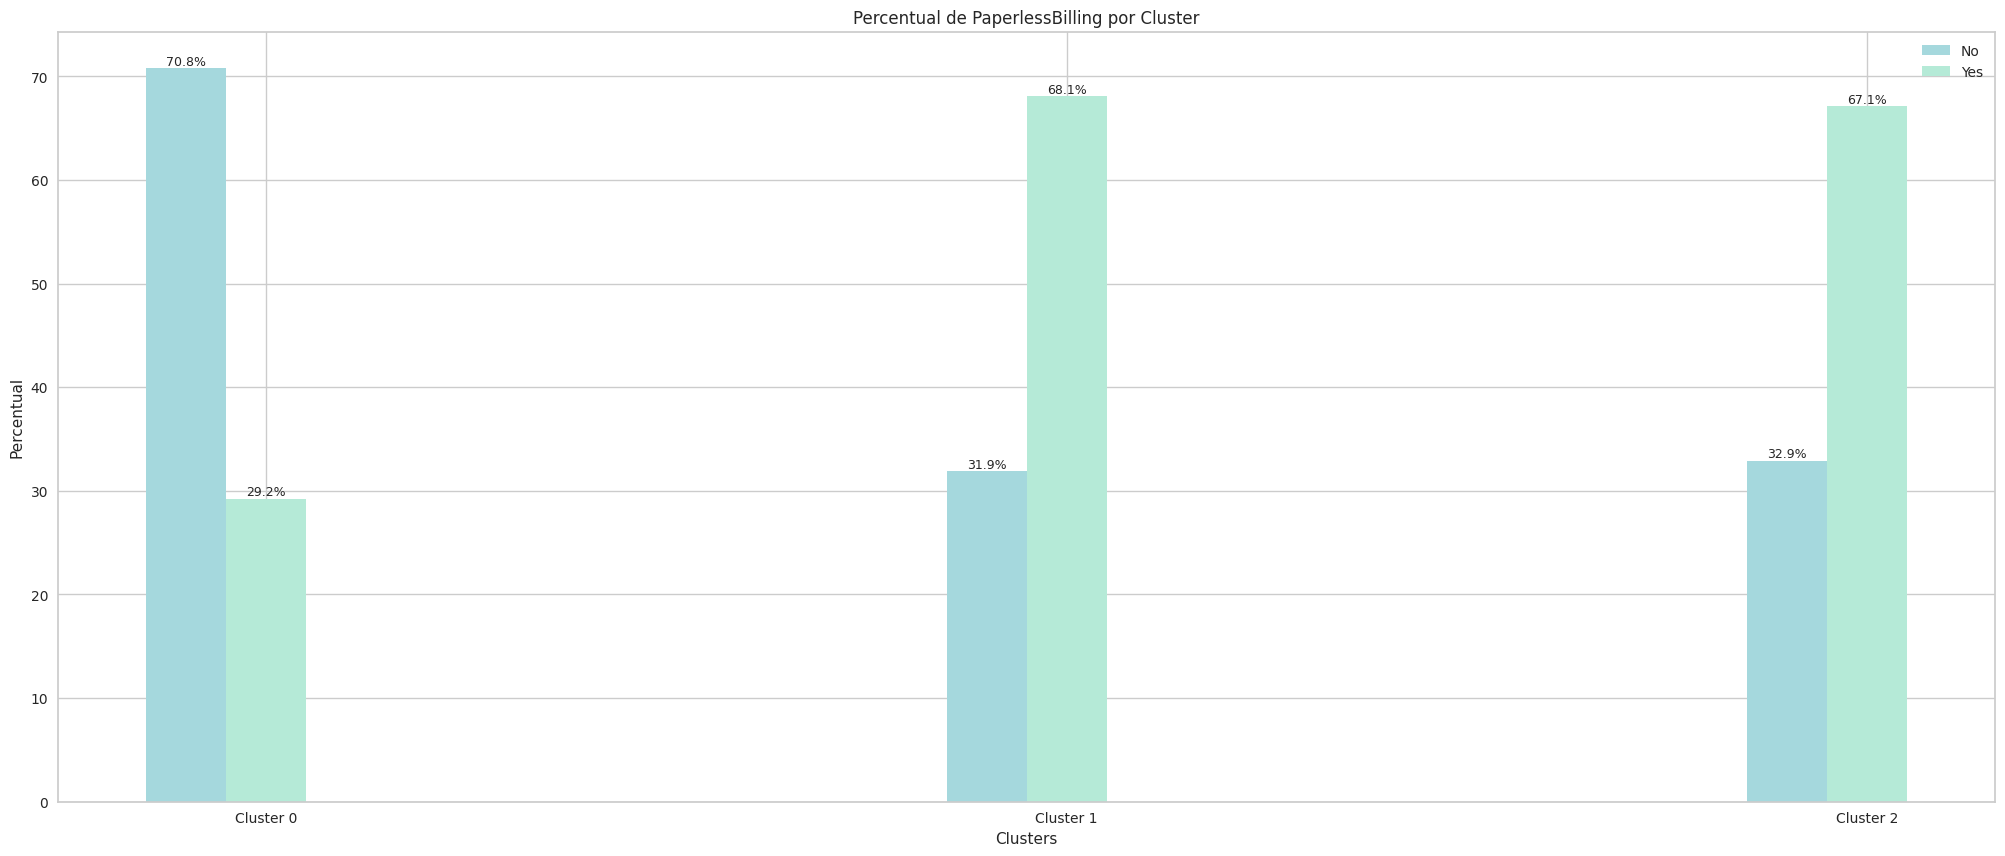

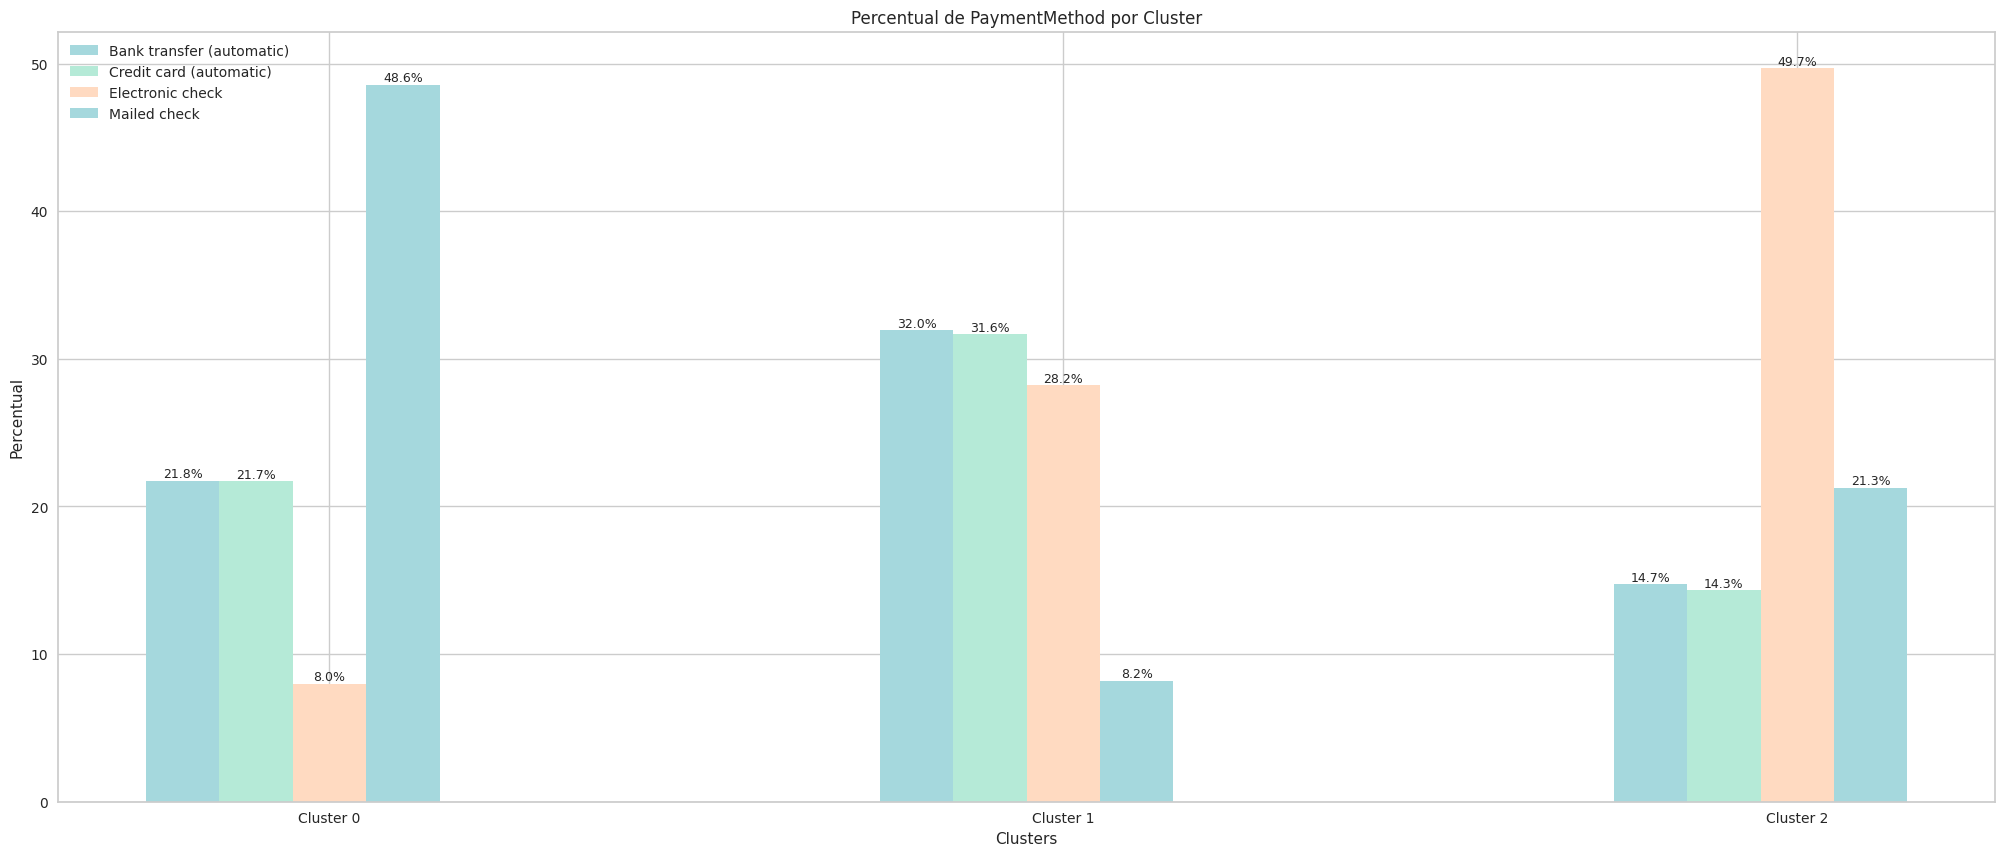

In [18]:
# Variáveis a serem analisadas:
vars1 = list(cat_attributes.columns).copy()

vars_categoricas = vars1

for var in vars_categoricas:
  percentuais_por_cluster = df.groupby('Cluster')[var].value_counts(normalize=True).mul(100).unstack().reset_index().values

  # Extrair os clusters e os percentuais de satisfação
  clusters = percentuais_por_cluster[:, 0]
  percentuais = percentuais_por_cluster[:, 1:]

  # Largura da barra
  bar_width = 0.1

  # Coordenadas das barras
  x = np.arange(len(clusters))

  # Plotar o gráfico de barras
  plt.figure(figsize=(25, 10))

  unicos = sorted(df[var].unique())
  for i in range(len(percentuais[0])):
      cor = pal[i % len(pal)] 
      j = unicos[i]
      plt.bar(x + i * bar_width, percentuais[:, i], bar_width, label=f'{j}', color=cor)
      for j, val in enumerate(percentuais[:, i]):
          plt.text(x[j] + i * bar_width, val, '{:.1f}%'.format(val), ha='center', va='bottom', fontsize=9);

  # Adicionar rótulos e título
  plt.xlabel('Clusters');
  plt.ylabel('Percentual');
  plt.title(f'Percentual de {var} por Cluster');
  plt.xticks(x + bar_width * len(percentuais[0]) / 2, [f'Cluster {int(cluster)}' for cluster in clusters]);
  plt.legend(loc='best');

  # Mostrar o gráfico
  plt.show();

## Númericas

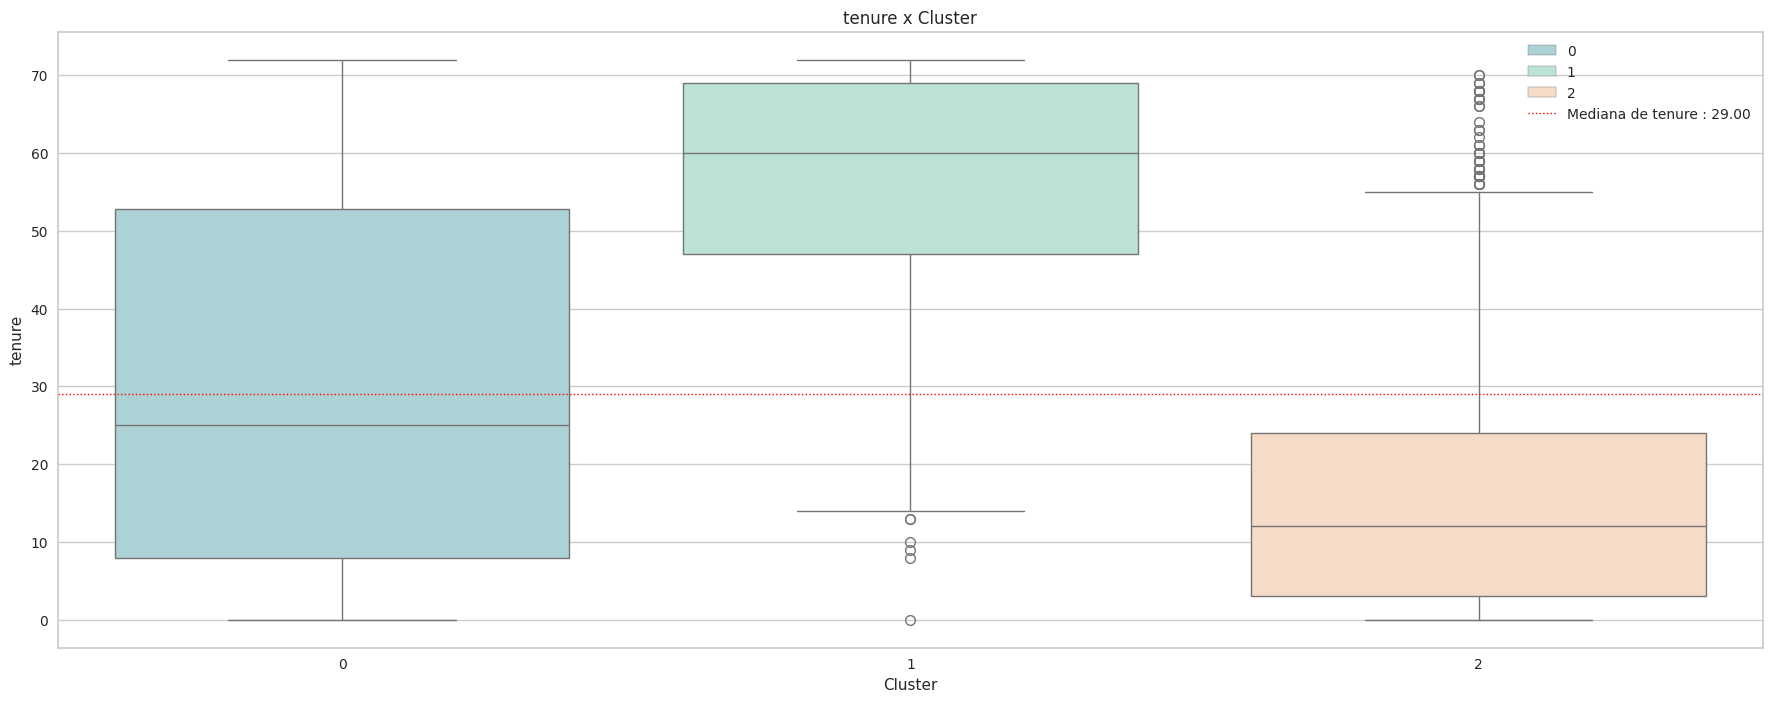

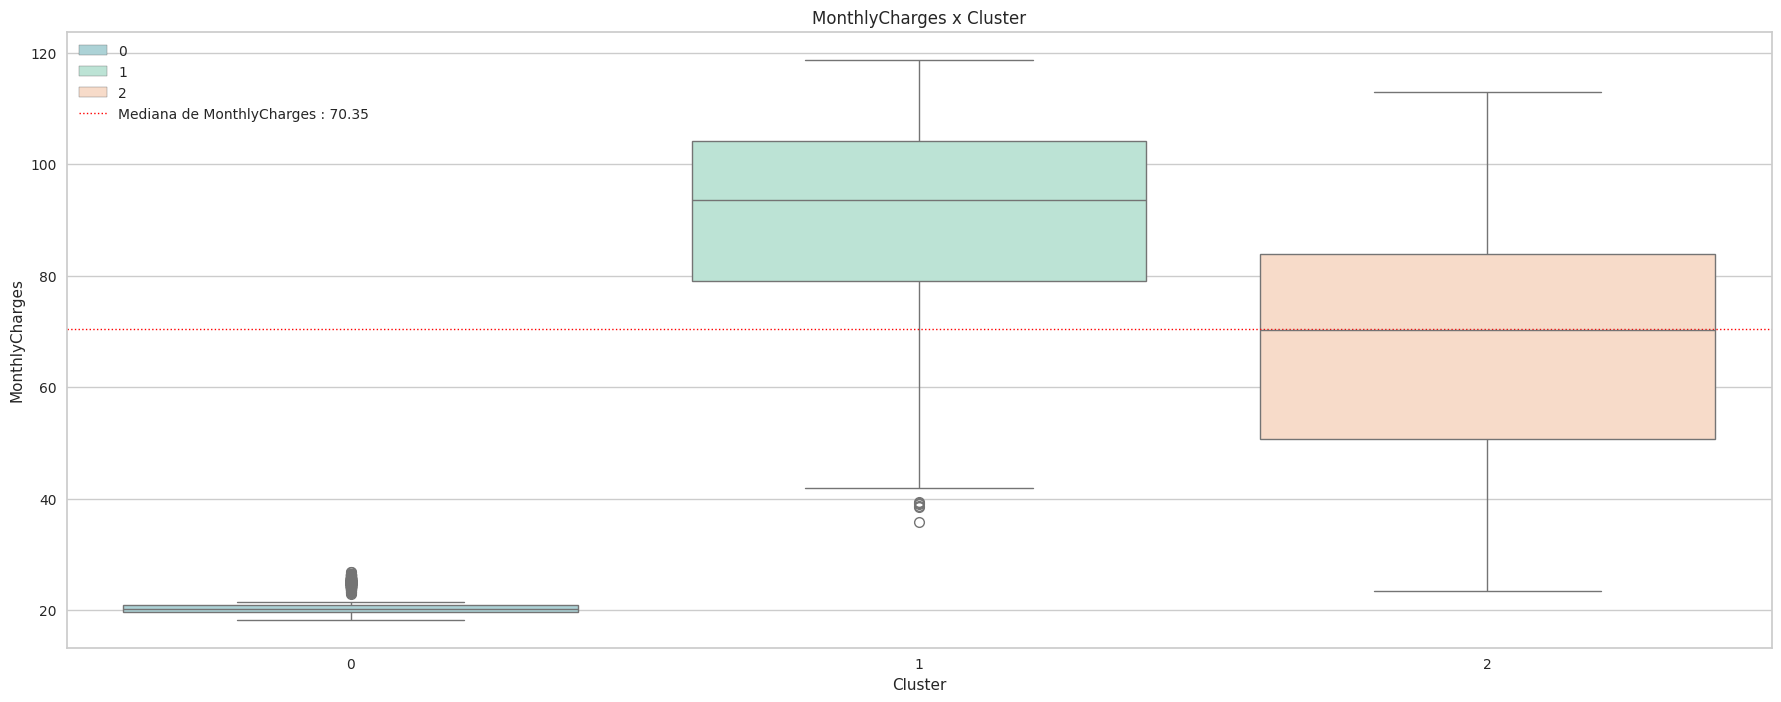

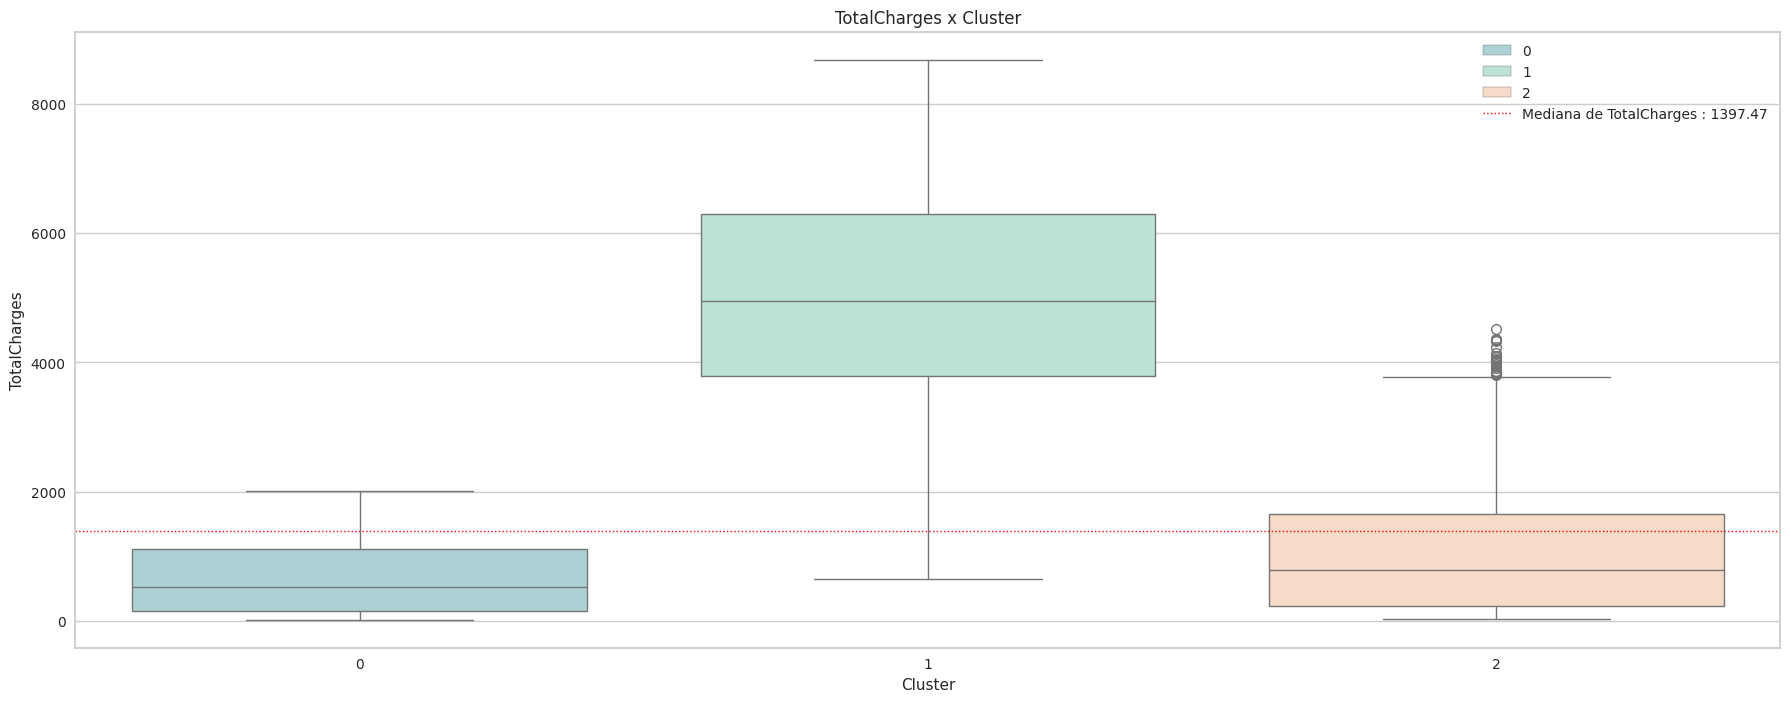

In [21]:

vars2 = list(num_attributes.columns).copy()
vars2 = [var for var in vars2 if var not in ['Churn', 'TARGET', 'SeniorCitizen']]
vars_numericas = vars2

for var in vars_numericas:
  plt.figure(figsize=(22, 8))
  pl=sns.boxplot(x=df["Cluster"], y=df[var], palette= pal, hue=df["Cluster"])

  mediana = df[var].median()
  # Adicionando uma linha indicando a média da variável de aceitacao
  text = f'Mediana de {var} :'+' {:.2f}'.format(mediana)
  plt.axhline(mediana, color='red', linestyle='dotted', linewidth=1, label=text)

  pl.set_title(f"{var} x Cluster")
  plt.legend()
  plt.show()



## Salvando dataset após clusterização

In [23]:
df2 = df.copy()
df2 = df2.drop(columns=['TARGET'])
df2.to_excel('../data/df_clusterizado.xlsx')